# Introduction to Convolutional Neural Networks

## 0. Import python libraries

First we need to import the python libraries that will be used along the notebook.
We will mainly use [Numpy](https://docs.scipy.org/doc/numpy-1.15.0/user/quickstart.html), [Matplotlib](https://matplotlib.org/tutorials/index.html), [Keras](https://keras.io/getting-started/sequential-model-guide/) and [Scikit-Learn](https://scikit-learn.org/stable/tutorial/index.html). We provide links to tutorials so that you can learn more by yourself or use them to modify the current code.

In [7]:
import gc # gc is the Garbage Collector library. It is used to empty memory from GPU and CPU.
import numpy as np # Numpy is the standard Python library to do operation with arrays.
import matplotlib.pyplot as plt # Matplotlib is the standard Python library to plot data.
## Keras is the library that we will use to build and train CNNs
from keras.datasets import mnist
from keras.utils import to_categorical
import keras.backend as K
from keras import models
from keras import layers
from keras.optimizers import SGD
## We will use scikit-learn tools to plot the performance of our network
from sklearn.metrics import confusion_matrix

%matplotlib inline


In [8]:
import matplotlib
import tensorflow as tf
import keras
import sklearn
print("Numpy ", np.__version__)
print("Matplotlib ", matplotlib.__version__)
print("Tensorflow ", tf.__version__)
print("Keras ", keras.__version__)
print("Scikit-learn ", sklearn.__version__)

Numpy  1.16.4
Matplotlib  3.1.0
Tensorflow  1.14.0
Keras  2.2.4
Scikit-learn  0.21.2


### 0.1 Explore modules and functions
Most functions and modules have a documentation that describes what they are doing and what their inputs and outputs are. In jupyter, you can access this documentation by putting a `?` in front of them. 

In [9]:
? to_categorical

A short version of it can be obtained by pressing **Shift + Tab** keys while the cursor is in the function name.

In [10]:
to_categorical

<function keras.utils.np_utils.to_categorical(y, num_classes=None, dtype='float32')>

## 1. Simple example with artificial data
Before working with real data we are going to generate simple artificial images and train simple convolutional neural network to identify them. 

### 1.2 Create the four images (/, \, X, O)
Images are arrays with numbers ranging from $0-255$. Following the examples in the theoretical lessons, we will generate a slash, a backslash, a cross and a circle with 16 (4x4) pixels. 

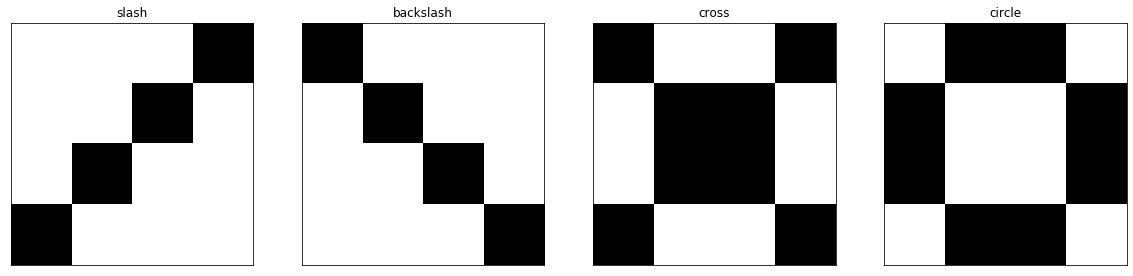

In [11]:
slash = np.asarray([[255, 255, 255, 0],[255, 255, 0, 255],[255, 0, 255, 255],[0, 255, 255, 255]])
backslash = np.asarray([[0, 255, 255, 255],[255, 0, 255, 255],[255, 255, 0, 255],[255, 255, 255, 0]])
cross = np.asarray([[0, 255, 255, 0],[255, 0, 0, 255],[255, 0, 0, 255],[0, 255, 255, 0]])
circle = np.asarray([[255, 0, 0, 255],[0, 255, 255, 0],[0, 255, 255, 0],[255, 0, 0, 255]])
labels=['slash', 'backslash', 'cross', 'circle']
# We visualize the images with Matplotlib
fig, axes = plt.subplots(1,4, figsize=(20,5))
images = [slash, backslash, cross, circle]
for i in range(4):
    ax = axes[i]
    ax.set_title(labels[i])
    ax.imshow(images[i], cmap='gray')
    ax.get_yaxis().set_visible(False) # do not show yaxis
    ax.get_xaxis().set_visible(False) # do not show xaxis

### 1.3 Create more "realistic" versions of the same images adding some noise
Images of objects are typically not perfect, and it does not exist the image of a perfect car or perfect bicycle. So we are going to generate more realistic version of our 4 images adding some white noise.
We will add noise by drawing samles from a normal distribution centered at cero (using `np.random.randn` from numpy). We can change the scale of the noise mutiplying by constant. We will keep the images bounded between $0$ and $255$ with the function `np.clip`. 

In [12]:
noise_scale = 10
n_images_per_class = 100
real_slashes = np.asarray([np.clip(slash + noise_scale*np.random.randn(4,4), 0, 255) 
                           for i in range(n_images_per_class)])
real_backslashes = np.asarray([np.clip(backslash + noise_scale*np.random.randn(4,4), 0, 255) 
                               for i in range(n_images_per_class)])
real_crosses = np.asarray([np.clip(cross + noise_scale*np.random.randn(4,4), 0, 255) 
                           for i in range(n_images_per_class)])
real_circles = np.asarray([np.clip(circle + noise_scale*np.random.randn(4,4), 0, 255) 
                           for i in range(n_images_per_class)])
images_list = [real_slashes, real_backslashes, real_crosses, real_circles]
# Here we are giving a numberical label from 0-3 to our images. 
labels_list = [np.ones(n_images_per_class).astype(int)*i for i in range(4)]
# We concatenate our list of images an labels to have a single array. 
all_images = np.concatenate(images_list, axis=0)
all_labels = np.concatenate(labels_list, axis=0)
print(all_images.shape)
print(all_labels.shape)
print(all_images.min(), all_images.max())

(400, 4, 4)
(400,)
0.0 255.0


We want the images to be normalised to avoid large number. There are many ways of normalising the images. here we just subtract $255/2$ and divide by $255/2$ so that the range will be from -1. to 1.

In [13]:
# Normalize images
all_images = (all_images - 127.5)/127.5
print(all_images.min(), all_images.max())

-1.0 1.0


As we will be using mini-batches for the training we want the images to be uniformely distributed in our dataset so that some batches do not inclue only images of one class. We can do this generating a permutation of numbers with the function `np.random.permutation`. We need to remember to permute also the labels.

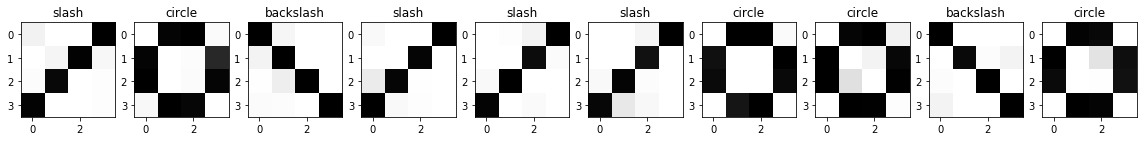

In [14]:
# Shuffle images
perm = np.random.permutation(4*n_images_per_class)
all_images = all_images[perm]
all_labels = all_labels[perm]
# We visualize the new images using matplotlib
n_images = 10
fig, axes = plt.subplots(1, n_images, figsize=(20,5))
for i in range(n_images):
    axes[i].set_title(labels[all_labels[i]])
    axes[i].imshow(all_images[i,:,:], vmin=all_images.min(), vmax=all_images.max(), cmap='gray')

Note that even if the images are a bit noisy we can still distinguish the 4 different images, so we expect the network to be able to distinguish them as well. 

### 1.4 Add channels dimension to images and put labels in one_hot representation
Images typically include 3 channels (red, green, blue). Our images have a single channel (gray_scale), however our array of images is missing one dimenions. We can add the channels dimension using the function `np.expand_dims`. 

In [15]:
print(all_images.shape)
all_images = np.expand_dims(all_images, axis=3)
print(all_images.shape)

(400, 4, 4)
(400, 4, 4, 1)


Before we encoded the labels of the images with numbers from 0-3. However, to be able to compare with probabilities (the output of our network), we need to encode the labels with the "one-hot" representation. We can do that using the function `to_categorical` that we imported from Keras (see first code cell). 

In [16]:
print(all_labels.shape)
all_labels_one_hot = to_categorical(all_labels)
for i in range(10):
    print("{} -> {}".format(all_labels[i], all_labels_one_hot[i])) 
print(all_labels_one_hot.shape)

(400,)
0 -> [1. 0. 0. 0.]
3 -> [0. 0. 0. 1.]
1 -> [0. 1. 0. 0.]
0 -> [1. 0. 0. 0.]
0 -> [1. 0. 0. 0.]
0 -> [1. 0. 0. 0.]
3 -> [0. 0. 0. 1.]
3 -> [0. 0. 0. 1.]
1 -> [0. 1. 0. 0.]
3 -> [0. 0. 0. 1.]
(400, 4)


### 1.5 Separate training, validation, and test
Now we are going to separate the arrays of images and labels into three different sets: training, validation and test. We will use a proportion 80% training 10% valiation and 10% test. 

In [17]:
p_sets = np.cumsum([.8, .1, .1])
total_number_of_images = all_images.shape[0]
X_train = all_images[:int(p_sets[0]*total_number_of_images)]
Y_train = all_labels_one_hot[:int(p_sets[0]*total_number_of_images)]
X_validation = all_images[int(p_sets[0]*n_images_per_class*4):int(p_sets[1]*total_number_of_images)]
Y_validation = all_labels_one_hot[int(p_sets[0]*n_images_per_class*4):int(p_sets[1]*total_number_of_images)]
X_test = all_images[int(p_sets[1]*total_number_of_images):int(total_number_of_images)]
Y_test = all_labels_one_hot[int(p_sets[1]*total_number_of_images):int(total_number_of_images)]
# Y_test = all_labels[int(.95*n_images_per_class*4):int(n_images_per_class*4)]
print(X_train.shape, Y_train.shape)
print(X_validation.shape, Y_validation.shape)
print(X_test.shape, Y_test.shape)

(320, 4, 4, 1) (320, 4)
(40, 4, 4, 1) (40, 4)
(40, 4, 4, 1) (40, 4)


### 1.6 Build neural network
We will use Keras to build and train the CNN model. In particular, we will use the Sequential mode of building networks.

In [18]:
cnn = models.Sequential() # This states that the model is a linear stack of layers
# we will use the option method .add to add more layers to our model
# first we add the convolutional layer
cnn.add(layers.Conv2D(filters=2, 
                      kernel_size=(2, 2), 
                      strides=(2, 2),
                      padding='valid', # This indicates that we are no adding any padding
                      input_shape=(4, 4, 1), 
                      activation='relu',
                      kernel_initializer='random_normal',
                      bias_initializer='zeros'))
cnn.add(layers.Flatten()) # This arranges the output of the maxpooling layer into a single vector
cnn.add(layers.Dense(units=Y_train.shape[1], #This indicates the number of outputs of the fully connected
                     activation='softmax',
                     kernel_initializer='random_normal', 
                     bias_initializer='zeros'))

W0821 10:11:47.387369 140582563383104 deprecation_wrapper.py:119] From /home/pacorofe/miniconda3/envs/idtrackerai_notebooks/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0821 10:11:47.396185 140582563383104 deprecation_wrapper.py:119] From /home/pacorofe/miniconda3/envs/idtrackerai_notebooks/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0821 10:11:47.397447 140582563383104 deprecation_wrapper.py:119] From /home/pacorofe/miniconda3/envs/idtrackerai_notebooks/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4115: The name tf.random_normal is deprecated. Please use tf.random.normal instead.



We compile the model and indicate the way we want to train it and which metrics we want to save. We will use stochastic gradient descent (`SGD`) optimizer imported from Keras (see first code cell) with lerning rate of 0.01. The error function used to measure the failures of the network will be the `categorical_crossentropy`. Finally, we will ask save the accuracy of the network at each step. 

In [19]:
cnn.compile(optimizer= SGD(lr=0.05),
            loss='categorical_crossentropy', # This sets the error function
            metrics=['accuracy'])

W0821 10:11:51.935824 140582563383104 deprecation_wrapper.py:119] From /home/pacorofe/miniconda3/envs/idtrackerai_notebooks/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0821 10:11:51.941389 140582563383104 deprecation_wrapper.py:119] From /home/pacorofe/miniconda3/envs/idtrackerai_notebooks/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.



Let's fit the parameters of our network. We will pass the data through the network 500 times (500 epochs) in batches of 100 imges. To check the performance of the network with images that will not be used for training we use the validation set. 

In [21]:
history=cnn.fit(X_train, Y_train,
                validation_data=(X_validation, Y_validation), 
                epochs=200, 
                batch_size=100)

Train on 320 samples, validate on 40 samples
Epoch 1/200
320/320 [==============================] - 0s 33us/step - loss: 0.0753 - acc: 1.0000 - val_loss: 0.0816 - val_acc: 1.0000
Epoch 2/200
320/320 [==============================] - 0s 28us/step - loss: 0.0749 - acc: 1.0000 - val_loss: 0.0810 - val_acc: 1.0000
Epoch 3/200
320/320 [==============================] - 0s 65us/step - loss: 0.0744 - acc: 1.0000 - val_loss: 0.0806 - val_acc: 1.0000
Epoch 4/200
320/320 [==============================] - 0s 53us/step - loss: 0.0739 - acc: 1.0000 - val_loss: 0.0800 - val_acc: 1.0000
Epoch 5/200
320/320 [==============================] - 0s 51us/step - loss: 0.0734 - acc: 1.0000 - val_loss: 0.0794 - val_acc: 1.0000
Epoch 6/200
320/320 [==============================] - 0s 52us/step - loss: 0.0730 - acc: 1.0000 - val_loss: 0.0791 - val_acc: 1.0000
Epoch 7/200
320/320 [==============================] - 0s 48us/step - loss: 0.0725 - acc: 1.0000 - val_loss: 0.0786 - val_acc: 1.0000
Epoch 8/200
320/3

320/320 [==============================] - 0s 56us/step - loss: 0.0540 - acc: 1.0000 - val_loss: 0.0587 - val_acc: 1.0000
Epoch 62/200
320/320 [==============================] - 0s 58us/step - loss: 0.0537 - acc: 1.0000 - val_loss: 0.0584 - val_acc: 1.0000
Epoch 63/200
320/320 [==============================] - 0s 55us/step - loss: 0.0535 - acc: 1.0000 - val_loss: 0.0580 - val_acc: 1.0000
Epoch 64/200
320/320 [==============================] - 0s 51us/step - loss: 0.0532 - acc: 1.0000 - val_loss: 0.0578 - val_acc: 1.0000
Epoch 65/200
320/320 [==============================] - 0s 50us/step - loss: 0.0530 - acc: 1.0000 - val_loss: 0.0575 - val_acc: 1.0000
Epoch 66/200
320/320 [==============================] - 0s 53us/step - loss: 0.0527 - acc: 1.0000 - val_loss: 0.0572 - val_acc: 1.0000
Epoch 67/200
320/320 [==============================] - 0s 49us/step - loss: 0.0524 - acc: 1.0000 - val_loss: 0.0569 - val_acc: 1.0000
Epoch 68/200
320/320 [==============================] - 0s 52us/step

320/320 [==============================] - 0s 50us/step - loss: 0.0416 - acc: 1.0000 - val_loss: 0.0452 - val_acc: 1.0000
Epoch 122/200
320/320 [==============================] - 0s 83us/step - loss: 0.0414 - acc: 1.0000 - val_loss: 0.0450 - val_acc: 1.0000
Epoch 123/200
320/320 [==============================] - 0s 41us/step - loss: 0.0412 - acc: 1.0000 - val_loss: 0.0448 - val_acc: 1.0000
Epoch 124/200
320/320 [==============================] - 0s 28us/step - loss: 0.0411 - acc: 1.0000 - val_loss: 0.0447 - val_acc: 1.0000
Epoch 125/200
320/320 [==============================] - 0s 39us/step - loss: 0.0409 - acc: 1.0000 - val_loss: 0.0445 - val_acc: 1.0000
Epoch 126/200
320/320 [==============================] - 0s 38us/step - loss: 0.0408 - acc: 1.0000 - val_loss: 0.0443 - val_acc: 1.0000
Epoch 127/200
320/320 [==============================] - 0s 51us/step - loss: 0.0406 - acc: 1.0000 - val_loss: 0.0441 - val_acc: 1.0000
Epoch 128/200
320/320 [==============================] - 0s 40

320/320 [==============================] - 0s 56us/step - loss: 0.0336 - acc: 1.0000 - val_loss: 0.0366 - val_acc: 1.0000
Epoch 182/200
320/320 [==============================] - 0s 90us/step - loss: 0.0335 - acc: 1.0000 - val_loss: 0.0365 - val_acc: 1.0000
Epoch 183/200
320/320 [==============================] - 0s 55us/step - loss: 0.0334 - acc: 1.0000 - val_loss: 0.0364 - val_acc: 1.0000
Epoch 184/200
320/320 [==============================] - 0s 46us/step - loss: 0.0333 - acc: 1.0000 - val_loss: 0.0362 - val_acc: 1.0000
Epoch 185/200
320/320 [==============================] - 0s 49us/step - loss: 0.0332 - acc: 1.0000 - val_loss: 0.0361 - val_acc: 1.0000
Epoch 186/200
320/320 [==============================] - 0s 53us/step - loss: 0.0331 - acc: 1.0000 - val_loss: 0.0360 - val_acc: 1.0000
Epoch 187/200
320/320 [==============================] - 0s 59us/step - loss: 0.0330 - acc: 1.0000 - val_loss: 0.0359 - val_acc: 1.0000
Epoch 188/200
320/320 [==============================] - 0s 52

We can visualize the evolution of the training (and validation) error function (loss) and accuracy using matplotlib.

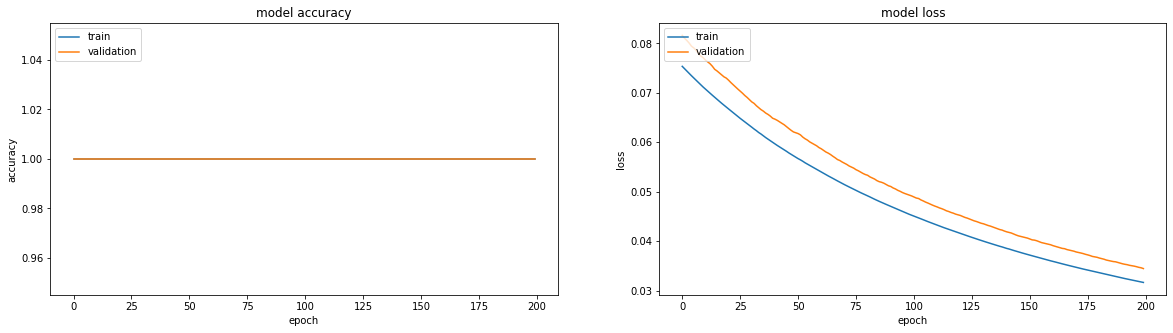

In [22]:
def plot_history(history):
    # summarize history for accuracy
    fig, axes = plt.subplots(1,2,figsize=(20,5))
    axes[0].plot(history.history['acc'])
    axes[0].plot(history.history['val_acc'])
    axes[0].set_title('model accuracy')
    axes[0].set_ylabel('accuracy')
    axes[0].set_xlabel('epoch')
    axes[0].legend(['train', 'validation'], loc='upper left')
    
    # summarize history for loss
    axes[1].plot(history.history['loss'])
    axes[1].plot(history.history['val_loss'])
    axes[1].set_title('model loss')
    axes[1].set_ylabel('loss')
    axes[1].set_xlabel('epoch')
    axes[1].legend(['train', 'validation'], loc='upper left')

plot_history(history)

Finally we can evaluate the performance of the network with the test set.

In [23]:
test_loss, test_acc = cnn.evaluate(X_test, Y_test)
print('test_acc:', test_acc)

40/40 [==============================] - 0s 111us/step
test_acc: 1.0


Another way of exploring the performance in a "per-class" way is looking at the confusion matrix. We will use the `confusion_matrix` function that we imported from sklearn.metrics to compute it.

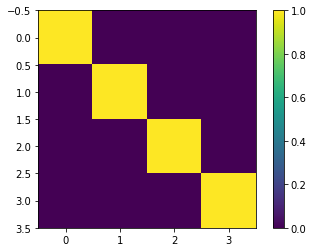

In [24]:
labels_predict = cnn.predict(X_test)
labels_predict = np.argmax(labels_predict, axis=1)
labels_test = np.argmax(Y_test, axis=1)
confusion_test=confusion_matrix(labels_test, labels_predict)
confusion_test = confusion_test.astype('float') / confusion_test.sum(axis=1)[:, np.newaxis]
plt.imshow(confusion_test, interpolation='none', vmin=0, vmax=1)
plt.colorbar();

Just out of curiosity we can explore the weights that the network learned and see how similar they are to the ones that we computed by hand for the "perfect" images.

(2, 2, 1, 2)
[[1.9913387 1.5542291]
 [1.4733508 1.9502665]]
[[-0.03266399 -0.02050182]
 [ 0.02685682  0.02498087]]


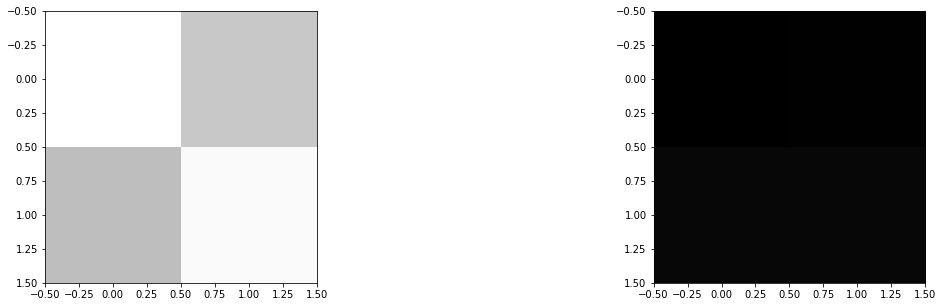

In [25]:
# get the symbolic outputs of each "key" layer (we gave them unique names).
layer_dict = dict([(layer.name, layer) for layer in cnn.layers])
conv_layer = [layer for layer in layer_dict if 'conv' in layer][0]
w = layer_dict[conv_layer].get_weights()[0]
print(w.shape)
n_filters = w.shape[-1]
fig, axes = plt.subplots(1,n_filters,figsize=(20,5))
for filter in range(n_filters):
    print(w[:,:,0,filter])
    axes[filter].imshow(w[:,:,0,filter], vmin=w.min(), vmax=w.max(), cmap='gray')

In [26]:
del(cnn) # This is to prevent GPU from filling up
K.clear_session()
gc.collect()

28503

# 2. Classifying handwritten digits with Convolutional Neural Networks (CNN)

In this notebook we will train a CNN to classify handwritten digits from the MNIST (Modified National Institute of Standards and Technology) database. 

## 2.1 Load and explore data

The [MNIST database](https://en.wikipedia.org/wiki/MNIST_database) is splitted in two different sets of images: the training set ($\{X_{train}\}$), and the test set ($\{X_{test}\}$).

The images in $\{X_{train}\}$ are used to learn the set of weigths ($\{\theta\}$) of the CNN.
The images in $\{X_{test}\}$ are used to check how well the learned weights work for images not used during the training.

Every set of images have associated a set of labels ($\{Y_{train}\}$, and $\{Y_{test}\}$).

In [ ]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data() # this loads a set of Numpy arrays

Let's explore the MNIST database by looking at the shape of the arrays loaded.

In [44]:
print("Training images array shape: {}. Training labels array shape: {}".format(X_train.shape, Y_train.shape))
print("Test images array shape: {}. Test labels array shape: {}".format(X_test.shape, Y_test.shape))

Training images array shape: (60000, 28, 28). Training labels array shape: (60000,)
Test images array shape: (10000, 28, 28). Test labels array shape: (10000,)


In this case, the first dimension of the array represents the number of elements in the array. 
The second and third dimmensions in the arrays $X_{train}$ and $X_{test}$ represent the size of the images. 

**Note 1**: The first dimension is the same for $X_{train}$ and $Y_{train}$ (same for $X_{test}$ and $Y_{test}$). This means that we have the same number of images than labels.  
**Think point 1**: Why do the arrays $Y_{train}$ and $Y_{test}$ have only dimensions 1?

In [45]:
print('Number of images in the training set: {}'.format(len(X_train)))
print('Number of images in the test set: {}'.format(len(X_test)))
print('Range training images: {}-{}'.format(X_train.min(), X_train.max()))
print('Range testing images: {}-{}'.format(X_test.min(), X_test.max()))
print('Size training images: {}'.format(X_train.shape[1:]))
print('Size testing images: {}'.format(X_test.shape[1:]))
print('Number of training labels:', len(Y_train))
print('Number of training labels:', len(Y_test))
print('Range training labels {}-{}:'.format(Y_train.min(), Y_train.max()))
print('Range testing labels {}-{}:'.format(Y_test.min(), Y_test.max()))

Number of images in the training set: 60000
Number of images in the test set: 10000
Range training images: 0-255
Range testing images: 0-255
Size training images: (28, 28)
Size testing images: (28, 28)
Number of training labels: 60000
Number of training labels: 10000
Range training labels 0-9:
Range testing labels 0-9:


Let's see how the images look like and check that the correspondence between images and labels are correct.

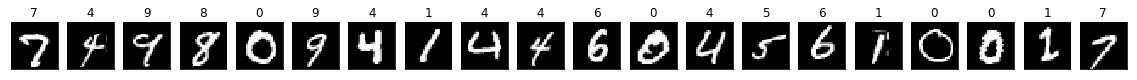

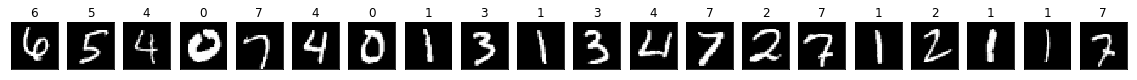

In [46]:
# The expression "def" is used in python to define functions.
# In this case there are two input arguments that are Numpy arrays: images and labels.
def show_images(images, labels):
    # This function uses matplotlib (plt) to plot a set of images
    fig, axes = plt.subplots(1, len(images), figsize=(20,10)) # Create figure and as many axes as images
    for image, label, ax in zip(images, labels, axes): # Loop through the images, labels and axes
        ax.set_title(label) # put the label as a title in the axes
        ax.imshow(image, cmap='gray', vmin=0, vmax=255) # show images
        ax.get_yaxis().set_visible(False) # do not show yaxis
        ax.get_xaxis().set_visible(False) # do not show xaxis
    
show_images(X_train[52:72], Y_train[52:72])
show_images(X_test[22:42], Y_test[22:42])

## 2.2 Prepare data for the CNN

### 2.2.1 Create a validation set

Most machine learning pipelines have three sets of images and labels (learn more in [this blog post](https://towardsdatascience.com/train-validation-and-test-sets-72cb40cba9e7)):

* **Training set**: Used to updated the weights of the network during training.

* **Validation set**: Used to monitor the performance of the network during training. This images are not used to update the weights.

* **Test set**: Used to check the performance of the network after training.

In our case, we only have a training and test set. We will create a validation set from the training set.

In [47]:
X_validation = X_train[50000:]
Y_validation = Y_train [50000:]
X_train = X_train[:50000]
Y_train = Y_train[:50000]

print("Training images {}. Training labels {}".format(X_train.shape, Y_train.shape))
print("Validation images {}. Validation labels {}".format(X_validation.shape, Y_validation.shape))
print("Test images {}. Test labels {}".format(X_test.shape, Y_test.shape))

Training images (50000, 28, 28). Training labels (50000,)
Validation images (10000, 28, 28). Validation labels (10000,)
Test images (10000, 28, 28). Test labels (10000,)


### 2.2.2 Convert labels to *one-hot* representation

Typically, for a given image $X$, the CNN outputs a vector of probabilities, $p(X)$, that tells us what is the probability that the image $X$ belongs to each of the possible labels in the problem. 

For example: If the network is good, and it is given an image of the number 3, it will output a vector of probabilities where the position 3 has a value very close to 1, and 0 otherwise:

$p(X) = [0., 0., 0., 0.99, 0, 0.01, 0, 0, 0, 0]$

To be able to compare predicted probabilities with the true labels we need to transform the labels with range $0-9$ to vectors where the element with the index corresponding to the label is 1. 

For example: The label for the number 6 can be represented with the following vector:

$y = [0, 0, 0, 0, 0, 0, 1, 0, 0, 0]$

This representation is sometimes called *one-hot* representation. The more common representation with range $0-9$ is sometimes called *dense* representation. We can use the function `to_categorical` from *keras* (see import cell above) to transform our labels to *one-hot* representation. 

In [48]:
Y_train_onehot = to_categorical(Y_train)
Y_validation_onehot = to_categorical(Y_validation)
Y_test_onehot = to_categorical(Y_test)
for i in range(10):
    print("{} -> {}".format(Y_train[i], Y_train_onehot[i])) 

print([Y.shape for Y in [Y_train_onehot, Y_validation_onehot, Y_test_onehot]])

5 -> [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
0 -> [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
4 -> [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
1 -> [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
9 -> [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
2 -> [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
1 -> [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
3 -> [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
1 -> [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
4 -> [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
[(50000, 10), (10000, 10), (10000, 10)]


### 2.2.3 Convert images to *float32*
The images are arrays of numbers from $0-255$ and they are integers. Neural networks will perform operations that will require to work with higher precision. Thus, we will convert the image to the datatype *float32*. You can learn more about how computers represent numbers in [this tutorial](https://www3.ntu.edu.sg/home/ehchua/programming/java/datarepresentation.html).

In [49]:
X_train = X_train.astype(np.float32)
X_validation = X_validation.astype(np.float32)
X_test = X_test.astype(np.float32)

### 2.2.4 Normalise images
The range of the images is still $0-255$. There are many reasons why normalising the data is important, but mainly it helps for the convergence of the training. You can learn more [in this blog post](https://medium.com/@rrfd/standardize-or-normalize-examples-in-python-e3f174b65dfc)

In [50]:
X_train_normalised = (X_train - 127.5)/127.5
X_validation_normalised = (X_validation - 127.5)/127.5
X_test_normalised = (X_test - 127.5)/127.5
print(X_train_normalised.min(), X_train_normalised.max())
print(X_validation_normalised.min(), X_validation_normalised.max())
print(X_test_normalised.min(), X_test_normalised.max())

-1.0 1.0
-1.0 1.0
-1.0 1.0


### 2.2.5 Add *channels* dimension to images

Our images are gray-scale images, i.e. they only have one channel. Colour images are represented with three channels (red, green and blue). We will code the convolution operations with *Keras*, which will expect that the images have a *channel* dimension even if this is one. So, we need to expand the dimensions of our images.
We will use the function `expand_dims` from *Numpy* to do so. 

In [52]:
X_train_normalised_reshaped = np.expand_dims(X_train_normalised, axis=3)
X_validation_normalised_reshaped = np.expand_dims(X_validation_normalised, axis=3)
X_test_normalised_reshaped = np.expand_dims(X_test_normalised, axis=3)
print([X.shape for X in [X_train_normalised_reshaped, X_validation_normalised_reshaped, X_test_normalised_reshaped]])

[(50000, 28, 28, 1), (10000, 28, 28, 1), (10000, 28, 28, 1)]


## 2.3 Train Convolutional Neural Network

### 2.3.2 Build model

We are going to start with the simplest model possible: One convolutional layer with two filters of size 2x2 and ReLU activation, a maxpooling layer and a fully connected layer with softmax activation. 

In [53]:
cnn = models.Sequential() # This states that the model is a linear stack of layers
# we will use the option method .add to add more layers to our model
# first we add the convolutional layer
cnn.add(layers.Conv2D(filters=2, 
                      kernel_size=(2, 2), 
                      strides=(2, 2),
                      padding='valid', # This indicates that we are no adding any padding
                      input_shape=(28, 28, 1), 
                      activation='relu',
                      kernel_initializer='random_normal',
                      bias_initializer='zeros'))
cnn.add(layers.MaxPooling2D(pool_size=(2, 2),
                            strides=(2, 2), 
                            padding='valid'))
cnn.add(layers.Flatten()) # This arranges the output of the maxpooling layer into a single vector
cnn.add(layers.Dense(units=Y_train_onehot.shape[1], #This indicates the number of outputs of the fully connected
                     activation='softmax',
                     kernel_initializer='random_normal', 
                     bias_initializer='zeros'))

### 2.3.2 Set optimizer, loss, metrics and compile model

We will train (update the weights to get a good classification performance) the model using *stochastic gradient descent* (*SGD*). The function that we will use to measure the errors is the [*cross entropy*](https://gombru.github.io/2018/05/23/cross_entropy_loss/). Finally, we will ask the model to output also the *accuracy* of the classification

In [54]:
sgd = SGD(lr=0.1) # This sets the optimizer
cnn.compile(optimizer=sgd,
                loss='categorical_crossentropy', # This sets the error function
                metrics=['accuracy'])

### 2.3.3 Fit the parameters of the model.

Fitting the parametes of the model and training the model are kind of synonyms. We will fit (train) the model with the train dataset (normalised and reshaped) using the trained labels in *one-hot* format. We will monitor the stage of the training with the validation set (normalised and reshaped) with the validation labels in *one-hot* format. 

We will perform 50 training steps called *epochs*. In every epoch we will train in sub_steps of 128 images called *batches*. 

In [55]:
history=cnn.fit(X_train_normalised_reshaped, Y_train_onehot,
                validation_data=(X_validation_normalised_reshaped, Y_validation_onehot), 
                epochs=50, 
                batch_size=128)

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 3s 51us/step - loss: 0.8616 - acc: 0.7302 - val_loss: 0.4538 - val_acc: 0.8605
Epoch 2/50
50000/50000 [==============================] - 2s 42us/step - loss: 0.4351 - acc: 0.8638 - val_loss: 0.3772 - val_acc: 0.8819
Epoch 3/50
50000/50000 [==============================] - 2s 47us/step - loss: 0.3804 - acc: 0.8810 - val_loss: 0.3631 - val_acc: 0.8868
Epoch 4/50
50000/50000 [==============================] - 2s 44us/step - loss: 0.3600 - acc: 0.8880 - val_loss: 0.3608 - val_acc: 0.8856
Epoch 5/50
50000/50000 [==============================] - 2s 46us/step - loss: 0.3497 - acc: 0.8909 - val_loss: 0.3279 - val_acc: 0.8976
Epoch 6/50
50000/50000 [==============================] - 2s 44us/step - loss: 0.3439 - acc: 0.8939 - val_loss: 0.3418 - val_acc: 0.8950
Epoch 7/50
50000/50000 [==============================] - 2s 44us/step - loss: 0.3398 - acc: 0.8941 - val_loss: 0.3169 - val_acc

## 2.4. Plot results of the training

### 2.4.1 Plot the evolution of the accuracy and the loss (error function)

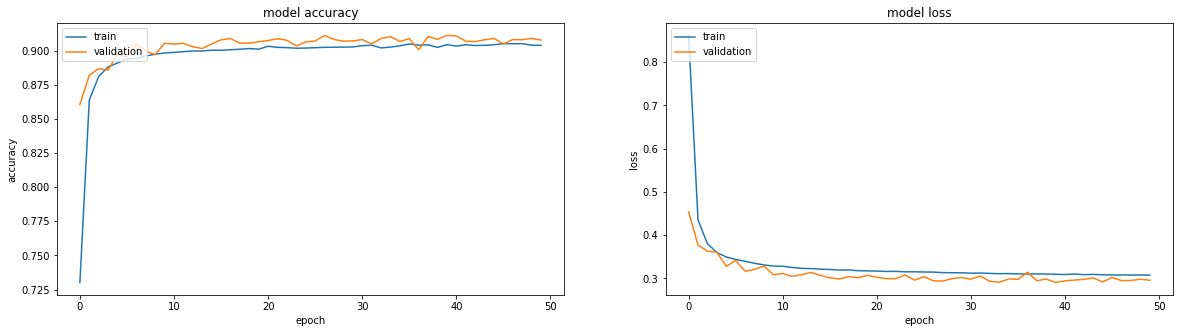

In [56]:
def plot_history(history):
    # summarize history for accuracy
    fig, axes = plt.subplots(1,2,figsize=(20,5))
    axes[0].plot(history.history['acc'])
    axes[0].plot(history.history['val_acc'])
    axes[0].set_title('model accuracy')
    axes[0].set_ylabel('accuracy')
    axes[0].set_xlabel('epoch')
    axes[0].legend(['train', 'validation'], loc='upper left')
    
    # summarize history for loss
    axes[1].plot(history.history['loss'])
    axes[1].plot(history.history['val_loss'])
    axes[1].set_title('model loss')
    axes[1].set_ylabel('loss')
    axes[1].set_xlabel('epoch')
    axes[1].legend(['train', 'validation'], loc='upper left')

plot_history(history)

### 2.4.3 Get the accuracy in the test set

In [57]:
test_loss, test_acc = cnn.evaluate(X_test_normalised_reshaped, Y_test_onehot)
print('test_acc:', test_acc)

10000/10000 [==============================] - 0s 37us/step
test_acc: 0.9044


We can also look at the confusion matrix. The diagonal elements represent the number of points for which the predicted label is equal to the true label, while off-diagonal elements are those that are mislabeled by the classifier. The higher the diagonal values of the confusion matrix the better, indicating many correct predictions.

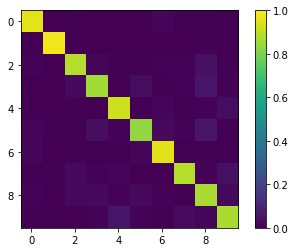

In [58]:
labels_predict=cnn.predict(X_test_normalised_reshaped)
labels_predict=np.argmax(labels_predict, axis=1)

confusion_test=confusion_matrix(Y_test, labels_predict)
confusion_test = confusion_test.astype('float') / confusion_test.sum(axis=1)[:, np.newaxis]
plt.imshow(confusion_test, interpolation='none', vmin=0, vmax=1)
plt.colorbar()

In [ ]:
del(cnn) # This is to prevent GPU from filling up
K.clear_session()
gc.collect()

# Exercises

### Ex 1: Explore the effect of the different hyperparameters in the performance of the classification:

Neural networks have parameters or weights that are learned to perform a given task. However, there are a set of parameters, usually called *hyperparameters*, that are chosen by hand. It requires
* Network architecture: Check the [Keras guide for sequential models](https://keras.io/getting-started/sequential-model-guide/) to see how to add more layers.
    - Number of convolutinal layers
    - Number of fully-connected layers
    - Number of filters and size of the filters
    - Strides, padding of the layers
* Optimizer
    - Optimization algorithm. In [this paper](https://arxiv.org/pdf/1609.04747.pdf) you can find a review of different optimizers. Most of them are already implemented in [Keras](https://keras.io/optimizers/).
    - Learning rate. In [this blog post](https://towardsdatascience.com/understanding-learning-rates-and-how-it-improves-performance-in-deep-learning-d0d4059c1c10) you can find a intuitive explanation on the effects of the learning rate.
    - Batch size. In [this paper](https://arxiv.org/pdf/1804.07612.pdf) they explore how the batch size affects the performance for some standard CNNs. In [this other paper](https://arxiv.org/pdf/1705.08741.pdf) they also explore the effects of using large batch sizes.
* Stopping criteria. 
    - Number of epochs
    - Early stopping considering the evolution of the validation loss. [This paper](https://www.researchgate.net/profile/Lutz_Prechelt/publication/2874749_Early_Stopping_-_But_When/links/551bc1650cf2fe6cbf75e533.pdf) explains the basics of early stopping. [Here](https://chrisalbon.com/deep_learning/keras/neural_network_early_stopping/) you can find an easy implementation of the early stopping in Keras. [Here](https://keras.io/callbacks/#earlystopping) you can find the Keras documentation.
* ...
        

### Ex 2: See how the performance of the network decreases when adding noisy and black-and-white versions of the images. 
You can use the following function to modify the images:
    
    def threshold_with_noise(images, threshold=0.5, noise_std=0):
        noise=np.random.rand(*images.shape)*noise_std
        return np.where(images+noise>threshold, 1.0, 0.0).astype('float32') 

### Ex 3: Visualise and explore the weights of convolutional layers
You can use the following command to create a dictionary of the layers:
    
    layer_dict = dict([(layer.name, layer) for layer in cnn.layers])

For the layers that have weights, you can use the method `get_weights` to access the weights and biases.

### Ex 4: Use a CNN to identify fish as we do in [idtracker.ai](idtracker.ai)

(7500, 52, 52) (7500,)
0 234
[10  3 10 ...  2  0 13] 0 14
New range: -0.10848107162123419 to 0.8915189283787658


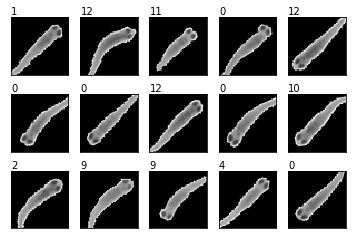

In [32]:
import os
CARP_PATH = './miniCARP/' # miniCARP should be already in this folder. Please let us know otherwise
def load_carp(fraction=1.0):
    folder = os.path.expanduser(CARP_PATH)
    images = np.load(os.path.join(folder,'miniCARP_images.npy'))
    labels = np.load(os.path.join(folder,'miniCARP_labels.npy'))
    num_images = int(np.floor(images.shape[0]*fraction))
    return images[:num_images], labels[:num_images]
images_uint8, all_labels = load_carp(fraction=0.1)

print(images_uint8.shape, all_labels.shape)
print(images_uint8.min(), images_uint8.max())
print(all_labels, all_labels.min(), all_labels.max())
NUM_LABELS = all_labels.max()+1

all_images = images_uint8 / images_uint8.max()
all_images = all_images - all_images.mean()
print("New range: {} to {}".format(all_images.min(), all_images.max()))

def show_images(images, labels=None):
    fig, axes_rows = plt.subplots(3, len(images)//3)
    axes = [ax for rows in axes_rows for ax in rows]
    for image, ax in zip(images, axes):
        ax.imshow(image,cmap=plt.cm.binary_r)
        ax.get_yaxis().set_visible(False)
        ax.get_xaxis().set_visible(False)
    if labels is not None:
        for label, ax in zip(labels, axes):
            ax.text(0, -3, label)
    plt.show()
show_images(all_images[200:215], labels=all_labels[200:215]) # Change range here to print other images

### Ex 5: Learn how to apply CNN to classify temporal data (word recognition) following [this tutorial](https://blog.manash.me/building-a-dead-simple-word-recognition-engine-using-convnet-in-keras-25e72c19c12b):


## Links and resources

* [Numpy](https://docs.scipy.org/doc/numpy-1.15.0/user/quickstart.html)
* [Matplotlib](https://matplotlib.org/tutorials/index.html)
* [Keras](https://keras.io/getting-started/sequential-model-guide/) 
* [Scikit-Learn](https://scikit-learn.org/stable/tutorial/index.html)
* [Medium](https://medium.com/topic/machine-learning)
* [Distill](https://distill.pub/)
* [Kaggle](https://www.kaggle.com/)